In [1]:
import torch
import math
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
from floods.utils.gis import imread
import random
import os
import matplotlib.pyplot as plt

In [2]:
blk = lambda ic, oc: nn.Sequential(
    nn.GroupNorm(32, num_channels=ic),
    nn.SiLU(),
    nn.Conv2d(ic, oc, 3, padding=1),
    nn.GroupNorm(32, num_channels=oc),
    nn.SiLU(),
    nn.Conv2d(oc, oc, 3, padding=1),
)


In [3]:
class ConsistencyModel(nn.Module):
    """
    This is ridiculous Unet structure, hey but it works!
    """

    def __init__(self, n_channel: int, eps: float = 0.002, D: int = 128) -> None:
        super(ConsistencyModel, self).__init__()

        self.eps = eps

        self.freqs = torch.exp(
            -math.log(10000) * torch.arange(start=0, end=D, dtype=torch.float32) / D
        )

        self.down = nn.Sequential(
            *[
                nn.Conv2d(n_channel, D, 3, padding=1),
                blk(D, D),
                blk(D, 2 * D),
                blk(2 * D, 2 * D),
            ]
        )

        self.time_downs = nn.Sequential(
            nn.Linear(2 * D, D),
            nn.Linear(2 * D, D),
            nn.Linear(2 * D, 2 * D),
            nn.Linear(2 * D, 2 * D),
        )

        self.mid = blk(2 * D, 2 * D)

        self.up = nn.Sequential(
            *[
                blk(2 * D, 2 * D),
                blk(2 * 2 * D, D),
                blk(D, D),
                nn.Conv2d(2 * D, 2 * D, 3, padding=1),
            ]
        )
        self.last = nn.Conv2d(2 * D + n_channel, n_channel, 3, padding=1)

    def forward(self, x, t) -> torch.Tensor:
        if isinstance(t, float):
            t = (
                torch.tensor([t] * x.shape[0], dtype=torch.float32)
                .to(x.device)
                .unsqueeze(1)
            )
        # time embedding
        args = t.float() * self.freqs[None].to(t.device)
        t_emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1).to(x.device)

        x_ori = x

        # perform F(x, t)
        hs = []
        for idx, layer in enumerate(self.down):
            if idx % 2 == 1:
                x = layer(x) + x
            else:
                x = layer(x)
                x = F.interpolate(x, scale_factor=0.5)
                hs.append(x)

            x = x + self.time_downs[idx](t_emb)[:, :, None, None]

        x = self.mid(x)

        for idx, layer in enumerate(self.up):
            if idx % 2 == 0:
                x = layer(x) + x
            else:
                x = torch.cat([x, hs.pop()], dim=1)
                x = F.interpolate(x, scale_factor=2, mode="nearest")
                x = layer(x)

        x = self.last(torch.cat([x, x_ori], dim=1))

        t = t - self.eps
        c_skip_t = 0.25 / (t.pow(2) + 0.25)
        c_out_t = 0.25 * t / ((t + self.eps).pow(2) + 0.25).pow(0.5)

        return c_skip_t[:, :, None, None] * x_ori + c_out_t[:, :, None, None] * x

    def loss(self, x, z, t1, t2, ema_model):
        x2 = x + z * t2[:, :, None, None]
        x2 = self(x2, t2)

        with torch.no_grad():
            x1 = x + z * t1[:, :, None, None]
            x1 = ema_model(x1, t1)

        return F.mse_loss(x1, x2)

    @torch.no_grad()
    def sample(self, x, ts: List[float]):
        x = self(x, ts[0])

        for t in ts[1:]:
            z = torch.randn_like(x)
            x = x + math.sqrt(t**2 - self.eps**2) * z
            x = self(x, t)

        return x


In [4]:
FOLDER_PATH = "/home/gabrielidis/These/flood/mmflood/processed_data/val"
model_path = "../saved_model/diffusion_model_3.pth"

In [5]:
model = ConsistencyModel(n_channel = 2, D= 256)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
x = torch.randn((8,2,512,512)) #https://mail.google.com/mail/u/0/?tab=rm&ogbl#starred/FFNDWNFNLkXxcqKTSXlWZnznZWMRJCJK bs,c,w,d
t = list(reversed([5.0, 10.0, 20.0, 40.0, 80.0])) 
output = model.sample(x,list(reversed([5.0, 10.0, 20.0, 40.0, 80.0])))

In [9]:
output[0][0]

tensor([[-0.0072, -0.0562,  0.1287,  ...,  0.0350,  0.0554, -0.0090],
        [-0.0097, -0.0396, -0.1107,  ...,  0.0356, -0.0171,  0.0594],
        [ 0.0575, -0.0125, -0.0037,  ...,  0.0895,  0.1189,  0.0826],
        ...,
        [-0.0442,  0.0119,  0.0070,  ..., -0.0073,  0.0844,  0.1389],
        [-0.0602,  0.0300, -0.0253,  ..., -0.0023,  0.0425,  0.0773],
        [-0.1184, -0.0164, -0.0019,  ...,  0.0303,  0.1023,  0.0173]])

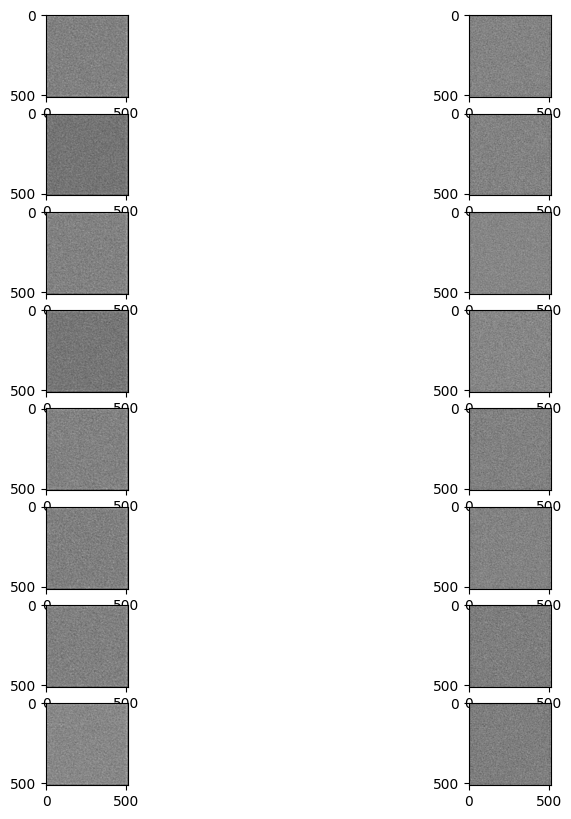

In [7]:
fig, axs = plt.subplots(8,2, figsize = (10,10))
for i in range(8):
    axs[i,0].imshow(output[i,0], cmap = "gray")
    axs[i,1].imshow(output[i,1], cmap = "gray")